In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve


In [2]:
hx = 1 # Шаг пространство
ht = 0.05 # Шаг время
N = 100 # Количество шагов по пространству
T = 50 # Количество шагов по времени
a = 1.0 # Коэф. температуропроводности материала
L = 100.0 # Крайняя координата пространства

In [3]:
def run_through(a, b, c, d):
    n = len(d)
    alpha = np.zeros(n - 1)
    beta = np.zeros(n)
    x = np.zeros(n)

    alpha[0] = c[0] / b[0]
    beta[0] = d[0] / b[0]
    for i in range(1, n - 1):
        coef = b[i] - a[i] * alpha[i - 1]
        alpha[i] = c[i] / coef
        beta[i] = (d[i] - a[i] * beta[i - 1]) / coef
    beta[-1] = (d[-1] - a[-1] * beta[-2]) / (b[-1] - a[-1] * alpha[-2])

    x[-1] = beta[-1]
    for i in range(n - 2, -1, -1):
        x[i] = beta[i] - alpha[i] * x[i + 1] 

    return x

In [4]:
def analytical_solution(x, t, u_initial, num_terms = 100, a=1.0):
    sum_terms = np.zeros_like(x)
    for m in range(1, num_terms):
        harmonic_m = (2 / L) * np.trapz(u_initial * np.sin(m * np.pi * x / L), x)
        sum_terms += harmonic_m * np.exp(- (m * np.pi / L) ** 2 * a * t) * np.sin(m * np.pi * x / L)
    return sum_terms

In [5]:
import math
def analytical_integral_solution(X, t, m=10, L=100, hx=1, N=100):
    i = 0
    T = np.zeros_like(X)    
    while i*hx < L:
        for m in range(1, N):
            x = i*hx
            beta = math.pi* m/L
            i1 = (50-0.1*x)*math.cos(beta*x)/beta + 0.1/(beta**2) * (math.sin(60*beta)-math.sin(50*beta))
            # i2 = (-0.01*x**2+1.6)*math.cos(beta*x)/(-beta) + 0.02/(beta**2)*(math.sin(70*beta)-math.sin(60*beta))
            i2 = -(0.01*x**2+1.2*x-36)*math.cos(beta*x)/beta + 0.02/beta*((60-x)*math.sin(beta*x)/beta - 1/beta**2 * (math.cos(70*beta)-math.cos(60*beta)))
            T[m] += 0.02*(i1+i2)*math.exp(-a*t*beta**2)*math.sin(beta*x)
            i+=1
    return T

In [6]:
x_steps = int(N)
time_steps = int(T / ht)

x = np.linspace(0, L, x_steps)
t = np.linspace(0, T, time_steps)
domain_length = 100.0

def f(x):
    if 50 <= x <= 60:
        return (x - 50) / 10
    elif 60 < x <= 70:
        return -((x - 60) ** 2) / 200 + 1
    return 0


u_initial = np.array([f(xi) for xi in x])
sigma = a * ht / (hx ** 2)

u_explicit = np.zeros((time_steps, x_steps))
u_explicit[0, :] = u_initial.copy()

for layer in range(1, time_steps):
    for i in range(1, x_steps - 1):
        u_explicit[layer, i] = u_explicit[layer-1, i] + sigma * (u_explicit[layer-1, i - 1] - 2 * u_explicit[layer-1, i] + u_explicit[layer-1, i + 1])

aux_diag = np.full(x_steps - 1, -sigma)
main_diag = np.full(x_steps, 1 + 2 * sigma)
u_implicit = np.zeros((time_steps, x_steps))
u_implicit[0, :] = u_initial.copy()

for layer in range(0, time_steps - 1):
    d = u_implicit[layer, :].copy()
    u_implicit[layer + 1, :] = run_through(aux_diag, main_diag, aux_diag, d)

u_analytical_last = analytical_solution(x, T, u_initial)
u_analytical_integral_last = analytical_solution(x, T, u_initial)


C:\Users\rassu\AppData\Local\Temp\ipykernel_11280\3559191052.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  harmonic_m = (2 / L) * np.trapz(u_initial * np.sin(m * np.pi * x / L), x)


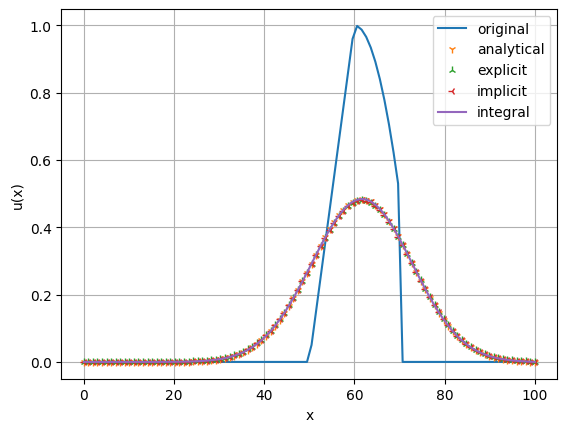

In [8]:
plt.plot(x, u_initial, label="original")      
plt.plot(x, u_analytical_last, linestyle="None", marker="1", label="analytical")  
plt.plot(x, u_explicit[-1, :], linestyle="None", marker="2", label="explicit") 
plt.plot(x, u_implicit[-1, :], linestyle="None", marker="3", label="implicit")
plt.plot(x, u_analytical_integral_last, label="integral")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend(loc="best")
plt.grid()
plt.show()